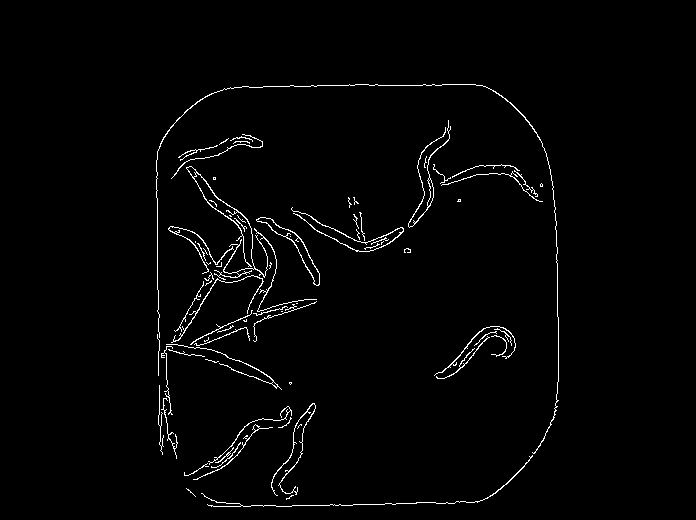

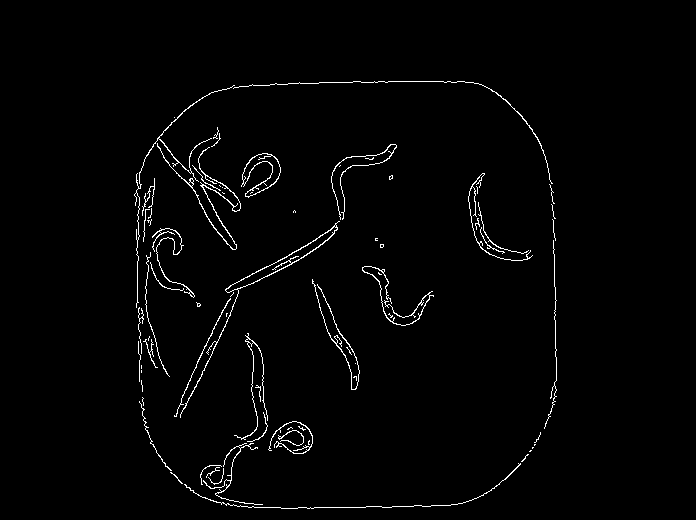

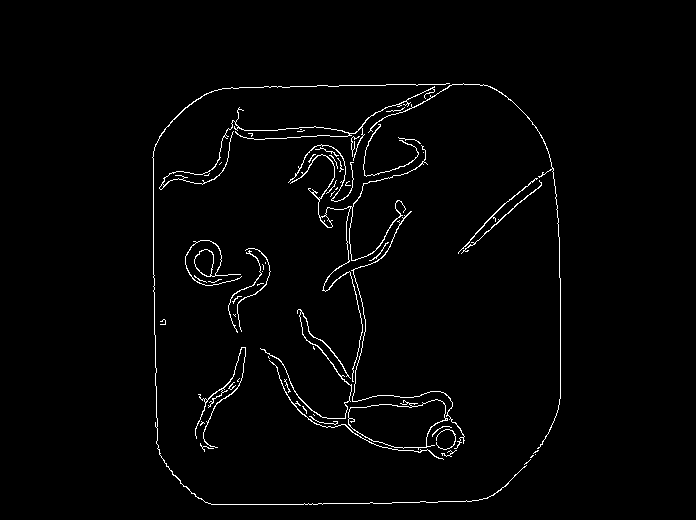

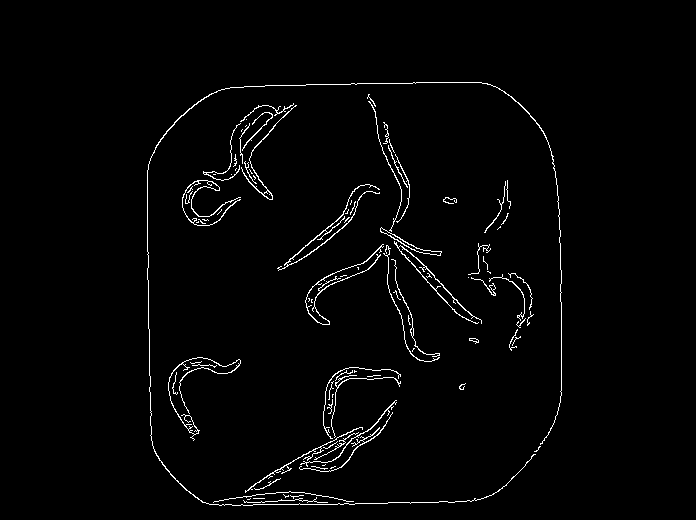

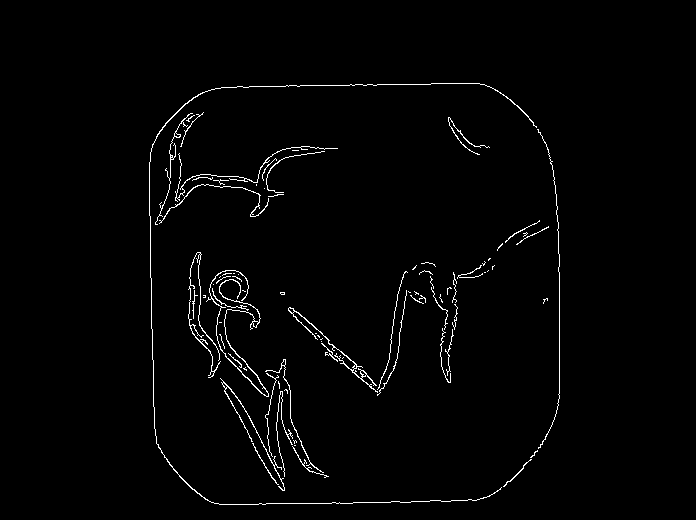

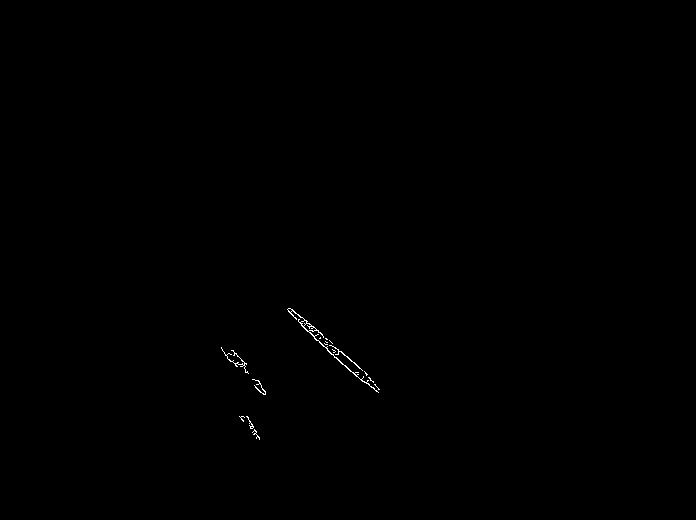

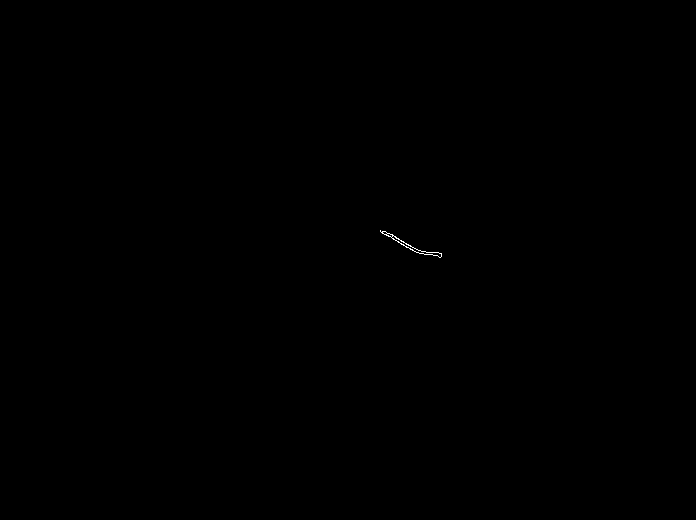

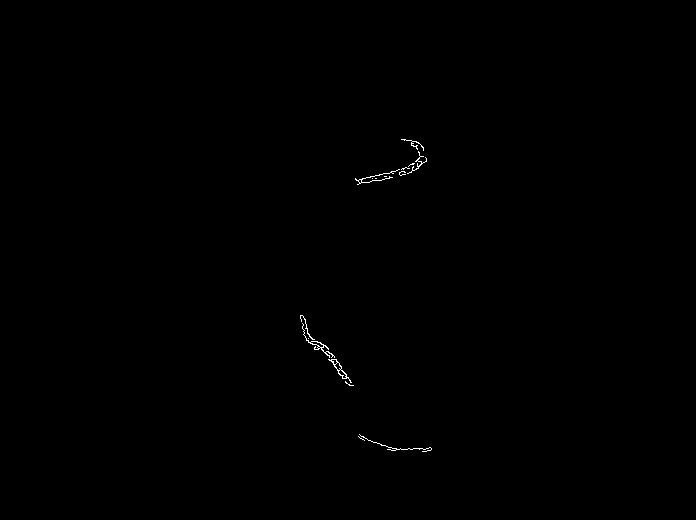

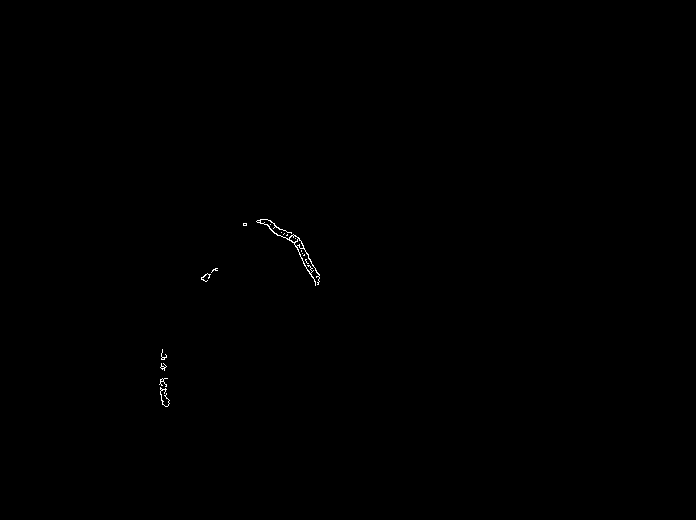

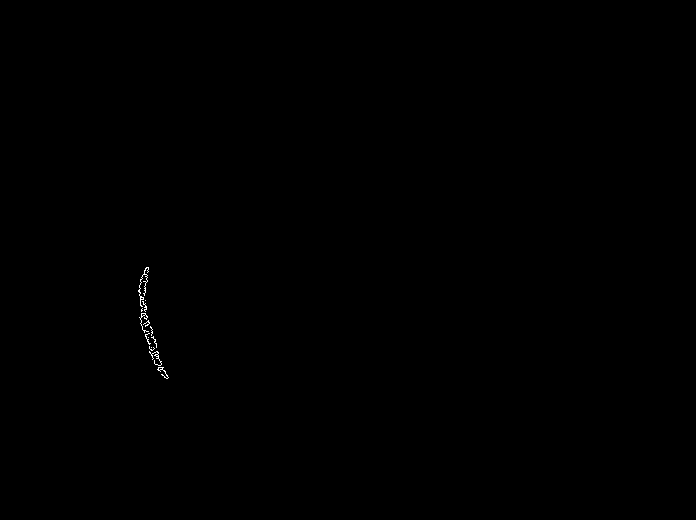

In [ ]:
import numpy as np
import os
from matplotlib import pyplot as plt
import cv2
import random
import pickle
from google.colab.patches import cv2_imshow
file_list = []
class_list = []
DATADIR = "data"
# All the categories you want your neural network to detect
CATEGORIES = ["Hookworm","Normal"]

# The size of the images that your neural network will use
IMG_SIZE = 50

# Checking or all images in the data folder
for category in CATEGORIES :
  path = os.path.join(DATADIR, category)
  for img in os.listdir(path):
    image = cv2.imread(img)
    #image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
    #gray = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)
    #display(image)
    img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
    img_array = cv2.Canny(img_array, threshold1=3, threshold2=10)
    img_array = cv2.medianBlur(img_array,1)
    cv2_imshow(img_array)

training_data = []

def create_training_data():
	for category in CATEGORIES :
		path = os.path.join(DATADIR, category)
		class_num = CATEGORIES.index(category)
		for img in os.listdir(path):
			try :
				img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
				new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
				training_data.append([new_array, class_num])
			except Exception as e:
				pass

create_training_data()

random.shuffle(training_data)

X = [] #features
y = [] #labels

for features, label in training_data:
	X.append(features)
	y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# Creating the files containing all the information about your model
pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

pickle_in = open("X.pickle", "rb")
X = pickle.load(pickle_in)

In [ ]:
import tensorflow as tf 
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import pickle
from keras.models import model_from_json
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
# Opening the files about data
X = pickle.load(open("X.pickle", "rb"))
y = pickle.load(open("y.pickle", "rb"))

# normalizing data (a pixel goes from 0 to 255)
X = X/255.0

# Building the model
model = Sequential()
# 3 convolutional layers
model.add(Conv2D(32, (3, 3), input_shape = X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2 hidden layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))

model.add(Dense(128))
model.add(Activation("relu"))

# The output layer with 13 neurons, for 13 classes
model.add(Dense(13))
model.add(Activation("softmax"))

# Compiling the model using some basic parameters
model.compile(loss="sparse_categorical_crossentropy",
				optimizer="adam",
				metrics=["accuracy"])
y=np.array(y)
# Training the model, with 40 iterations
# validation_split corresponds to the percentage of images used for the validation phase compared to all the images
history = model.fit(X, y, batch_size=64, epochs=10, validation_split=0.1)

# Saving the model
model_json = model.to_json()
with open("model.json", "w") as json_file :
	json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")

model.save('CNN.model')

# Printing a graph showing the accuracy changes during the training phase
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
acc=np.array(acc)
val_acc=np.array(val_acc)
loss=np.array(loss)
val_loss=np.array(val_loss)
epochs_range = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
